In [1]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
import numpy as np
import matplotlib.pyplot as plt
import tqdm


# Prelim: generate an OpenMM system with Na and Cl ions in it to calculate the PMF over separation distance
Using a single water molecule PBD file to start, then adding solvent and ions with `Modeller`. We start with a pdb file holding just a single water. The first-occurring sodium and chloride atoms are chosen for biasing.  


In [2]:
pdb = PDBFile('tip3p-1.pdb')
omm_forcefield= ForceField('amber14/tip3pfb.xml')
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(omm_forcefield, ionicStrength=0.15*molar)
PDBFile.writeFile(modeller.topology, modeller.positions, file=open('solvated.pdb', 'w'))

sod = [i.index for i in modeller.topology.atoms() if i.residue.name=='NA'][0]
cla = [i.index for i in modeller.topology.atoms() if i.residue.name=='CL'][0]


# Prelim: create system, and add a custom force biasing the ion separation

`r0` will be the name of the parameter controlling separation, i.e. it is the centre of the restraint that holds the two ions at a particular distance apart.

In [3]:
system = omm_forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
         nonbondedCutoff=0.9*nanometer, constraints=HBonds)


nrg_expr = "k*(r-r0)^2"
ion_force = CustomBondForce(nrg_expr)
ion_force.addGlobalParameter('k', 100*kilocalorie_per_mole**2)
ion_force.addGlobalParameter('r0', 1*nanometer)
ion_force.addBond(sod, cla, [])
ion_force.setUsesPeriodicBoundaryConditions(True)
system.addForce(ion_force)

integrator = LangevinIntegrator(298*kelvin, 1/picosecond, 2*femtosecond)
platform = Platform.getPlatformByName('OpenCL')
prop = {'OpenCLPrecision':'single'}

simulation = Simulation(modeller.topology, system, integrator, platform, prop)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()

# Prelim: run a short equilibration 

In [4]:
pe = list()
distances = list()
for i in tqdm.tqdm_notebook(range(1000)):
    simulation.step(50)
    state = simulation.context.getState(getEnergy=True)
    nrg = state.getPotentialEnergy()
    pe.append(nrg)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


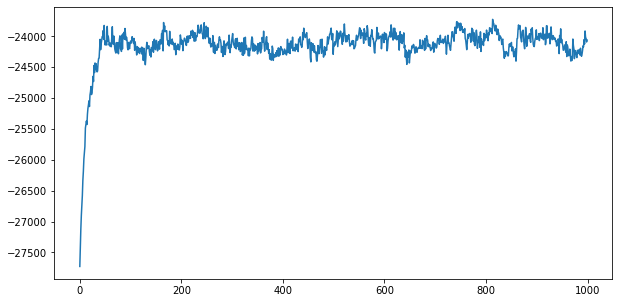

In [5]:
fig, ax = plt.subplots()

fig.set_figwidth(10)
fig.set_figheight(5)

ax.plot([i/kilojoule*mole for i in pe])


# Calculate the PMF of ion separation with MBAR

The code for taking measurements in a convenient pyMBAR format, and then for analyzing the results with pyMBAR, is taken from http://openmm.org/tutorials/alchemical-free-energy/ .

In [ ]:
# Collect data
nsteps = 2000 # number of steps inbetween sampling the potential energy
niterations = 100 # number of samples to collect at each separation distance. 


nstates = len(levels)
u_kln = np.zeros([nstates,nstates,niterations], np.float64)
kT = AVOGADRO_CONSTANT_NA * BOLTZMANN_CONSTANT_kB * simulation.integrator.getTemperature()

for k in tqdm.notebook.tqdm(range(nstates)):
    for iteration in tqdm.notebook.tqdm(range(niterations)):
        # Set the separation distance:
        scaling_function(simulation, levels[k])
        # Sample in MD-space for a bit:
        simulation.step(nsteps)
        # Compute what the energy of the current configuration would be at ALL separations,
        # this is used to calculate energetic overlap between the states. 
        for l in range(nstates):
            scaling_function(simulation, levels[l])
            u_kln[k,l,iteration] = simulation.context.getState(getEnergy=True).getPotentialEnergy() / kT


In [ ]:
# Estimate free energy of Lennard-Jones particle insertion
from pymbar import MBAR, timeseries
# Subsample data to extract uncorrelated equilibrium timeseries
N_k = np.zeros([nstates], np.int32) # number of uncorrelated samples
for k in range(nstates):
    [nequil, g, Neff_max] = timeseries.detectEquilibration(u_kln[k,k,:])
    indices = timeseries.subsampleCorrelatedData(u_kln[k,k,:], g=g)
    N_k[k] = len(indices)
    u_kln[k,:,0:N_k[k]] = u_kln[k,:,indices].T
# Compute free energy differences and statistical uncertainties
mbar = MBAR(u_kln, N_k)
[DeltaF_ij, dDeltaF_ij,] = mbar.getFreeEnergyDifferences()


In [ ]:
# save the outputs if you want to replot later:
np.save('u_kln_mbar.npy', u_kln)

# Estimate the weights (i.e. free energy) using GSST 



In [ ]:
#this is just a shortcut to change the `r0` parameter
def scaling_function(simulation, level):
    simulation.context.setParameter('r0', level)
    
    
#we will calculate the PMF for 30 points between 0.15 nm and 0.9 nm
levels = np.arange(1.5,9,0.25)/10
    

from gsst import GSST

st = GSST(simulation=simulation, 
                              scaling_function=scaling_function,
                             levels=levels, 
                              changeInterval=1000,
                              cutoff=1e-5,
                              baseTemp=298*kelvin,
                              reportFile='gsst.dat'
                             )

#normally GSST starts from the zeroth state, but the ion is starting from a different state. 
#and would have to zoom back to the beginning! 
#Instead, set the currentLevel at any point, i.e. the final state used in MBAR, `k`.
st.currentLevel = k

In [ ]:
print('Progress towards cutoff\nleft:_weightUpdateFactor=1;\nright:_weightUpdateFactor=1e-8')
while st._weightUpdateFactor>1e-5:
    simulation.step(1000)
    
    #homemade progress bar:
    fraction = np.abs(np.log10(st._weightUpdateFactor)/5)
    print('|' + ' '*int((100*fraction)) + '*' + ' '*int(100*(1-fraction)) + '|', end='\r')
print('Finished')

In [ ]:
#check that it's below the update factor is below the cutoff, indicating convergence. 
st._weightUpdateFactor

# Plot the difference!

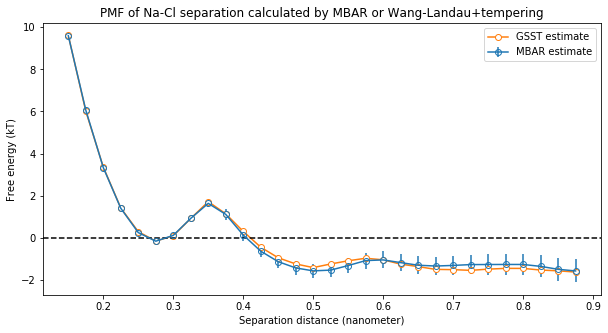

In [53]:
plt.figure(figsize=(10,5))

plt.errorbar(x=levels, 
             y=DeltaF_ij[0]-np.mean(DeltaF_ij[0]), 
             yerr = dDeltaF_ij[0], fmt='-o', mfc='none', label='MBAR estimate')

plt.plot(levels, 
             st.weights-np.mean(st.weights), '-o', mfc='white',label='GSST estimate')

plt.title('PMF of Na-Cl separation calculated by MBAR or Wang-Landau+tempering')
plt.legend()
plt.ylabel('Free energy (kT)')
plt.xlabel('Separation distance (nanometer)')
plt.axhline(0, linestyle='--', c='k')

plt.savefig('na_cl_pmf.png')

# If making a gif of the wang-landau estimates approaching the MBAR estimate:

In [49]:
import pandas as pd
pes = pd.read_csv('gsst.dat', sep='\t')
temp_pes = pes.iloc[np.linspace(0, len(pes)-1, 100).astype(int)]

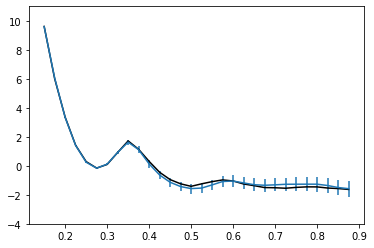

In [51]:
import matplotlib.animation as animation

x = levels
y = temp_pes.iloc[0,4:]

fig, ax = plt.subplots()
ax.errorbar(x=levels, y=DeltaF_ij[0]-DeltaF_ij[0].mean(), yerr = dDeltaF_ij[0])

line, = ax.plot(x, y, color='k')
ax.set_ylim(-4, 11)

def update(num, x, df, line):

    y = df.iloc[num, 4:]
    line.set_data(x, y-y.mean())

    return line,

ani = animation.FuncAnimation(fig, update, frames=len(temp_pes), fargs=[x, temp_pes, line], blit=True)

ani.save('wl_freenrg.gif',writer='imagemagick')
#plt.show()